# Random forest classification

Random Forest is a supervised learning algortihm that can be used for both classfication and regression. The algorithm builds multiple decision trees and merge them together to get a more stable and accurate prediction. Random Forest adds randomness to the model while increasing the number of trees. The algorithm searches for the next feature among a random subset of features, instead of trying to find the most important feature when deciding how the tree should be split. This gives a generally unbiased algorithm and generally results in a better model. However, when features are correlated, the method can be biased towards variables with many categories.  

While Random Forest does not perform feature reduction as it is, it does provide information about the importance of the features chosen from the algorithm. Using this information, we are thus able to make an educated decision on how to reduce the features in the best way. For this example, we will be using Recursive Feature Elimination with cross-validation (RFECV) to reduce the number of features. RFECV removes features through cross-validation by recursively considering smaller and smaller sets of features.

## Training and testing the model 

We will first create a framework to train and test the Random Forest classifier. The framework will include reading the training and test data, training the model and validating the accuracy of the model. 

In [1]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [2]:
# Set random state
SEED = 0

In [3]:
def read_data(filename, scaling=True, info=False):

    """ Function that reads file containing patient-info and gene expression
    and separates the data into data (X) and target (y). Option to get 
    additional information (survival data, gene-list). """

    # Read data
    data = pd.read_csv(filename, sep="\t", index_col=0, encoding="utf-8")

    # Save label information
    patients = data.index
    genes = data.columns[2:-3]
    
    # Survival data
    time = data["time"]
    event = data["event"]
    
    # Extract data and target for modeling
    data = data.dropna()
    X = data.loc[:,data.columns[2:-3]].values
    y = data["cluster2_2"].values

    # Option to scale data when needed
    if scaling == True:
        scaler = StandardScaler()
        
        # Scale the genes
        X = scaler.fit_transform(X) 

    # Option to get survival data
    if info == True:
        return X, y, patients, time, event, genes

    return X, y

In [4]:
# Read training and test data
X_train, y_train = read_data("data/training/merged_training_data.txt", scaling=False)
X_test, y_test, patients, T, E, genes = read_data("data/test/merged_test_data.txt", scaling=False, info=True)

In [5]:
# Random forest classifier
clf = RandomForestClassifier(random_state=SEED, n_jobs=8)

In [6]:
# Fit model
model = clf.fit(X_train, y_train)

In [ ]:
# Predict on training data
y_pred = clf.predict(X_train)

In [ ]:
# Compute accuracy of model on training data
acc_score_train = accuracy_score(y_train, y_pred)
print("Accuracy score on training data: ", acc_score_train)

In [ ]:
# Get number of features
print("Number of features when fit is performed: ", clf.n_features_)

In [ ]:
# Predict on test data
y_pred = clf.predict(X_test)

In [ ]:
# Compute accuracy for test
acc_score_test = accuracy_score(y_test, y_pred)
print("Accuracy score on test data: ",  acc_score_test)

## Feature reduction

In [ ]:
# Feature reduction with RFECV
rfecv = RFECV(clf, step=1000, cv=5, scoring="accuracy", n_jobs=16)
rfecv = rfecv.fit(X_train, y_train)
print("Optimal number of features after RFECV: ", rfecv.n_features_)

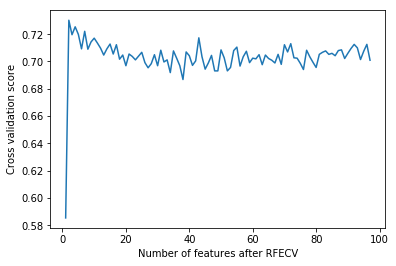

Optimal number of features after RFECV: 29


In [78]:
# Plot features vs cv score
plt.figure()
plt.xlabel("Number of features after RFECV")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()
print("Optimal number of features after RFECV: %d" % rfecv.n_features_)

In [79]:
# Train classifier with the selected features
X_train_selected = rfecv.transform(X_train)
clf_selected = RandomForestClassifier(random_state=SEED, n_jobs=8)
model_selected = clf_selected.fit(X_train_selected, y_train)

In [80]:
# Predict on selected training data
y_pred = clf_selected.predict(X_train_selected)

In [81]:
# Compute accuracy of model on selected training data
acc_score_train = accuracy_score(y_train, y_pred)
print("Accuracy score on training data after RFECV: ", acc_score_train)

Accuracy score on training data after RFECV:  0.9873928391326273


In [82]:
# Test classifier on selected features
X_test_selected = rfecv.transform(X_test)

In [83]:
# Predict on test data
y_pred = clf_selected.predict(X_test_selected)

In [84]:
# Compute accuracy for test
acc_score_test = accuracy_score(y_test, y_pred)
print("Accuracy score on test data  after RFECV: ",  acc_score_test)

Accuracy score on test data  after RFECV:  0.6126893939393939


In [85]:
# Create confusion matrix
conf_matrix = pd.crosstab(y_test, y_pred, rownames=['Actual cluster'], colnames=['Predicted cluster'])
print(conf_matrix)

Predicted cluster     0    1
Actual cluster              
0                  1154  218
1                   600  140


## ROC curve

In [86]:
# Compute false positives and true positives for all thresholds of classification  
probs = clf_selected.predict_proba(X_test_selected)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

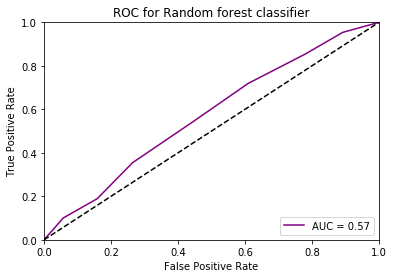

In [87]:
# Plot ROC curve
plt.title('ROC for Random forest classifier')
plt.plot(fpr, tpr, color='purple', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],color="black", linestyle="--")
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## Survival analysis

In [88]:
def kaplan_meier(df, ax, label):
    """ Function that estimates survival using the Kaplan-Meier estimator, given dataframe with 
    survival data. """

    # Get event and time from df
    E = df["event"] # dead = 1
    T = df["time"]
    T = T/365. # get time in years
    T = T.apply(lambda x: 15. if x >= 15. else x) # set time limit to 15 years

    # Compute surival estimates for all donor samples
    kmf = KaplanMeierFitter()
    kmf.fit(T, E, label=label)
    kmf.plot(ax=ax)

    return T, E, kmf.survival_function_

In [89]:
def estimate_based_on_clustering(df, ax):
    """ Function that estimates survival for each cluster in a dataframe. """
    
    # Cluster names and counts
    clusters = df.cluster2_pred.unique()
    cluster_counts = df.cluster2_pred.value_counts()
    
    # Estimate survival for each predicted cluster
    C1 = df.loc[df["cluster2_pred"] == 1]
    T1, E1, c1_surv_func = kaplan_meier(C1, ax, label="Cluster B (n=%d)" %cluster_counts[1])
    C2 = df.loc[df["cluster2_pred"] == 0]
    T2, E2, c2_surv_func = kaplan_meier(C2, ax, label="Not cluster B (n=%d)" %cluster_counts[0])

    # Logrank test
    res = logrank_test(T1, T2, E1, E2)

    return c1_surv_func, c2_surv_func, res.p_value

In [90]:
# Get survival data and the predicted cluster for test data
d = {"samplename": patients, "time": T, "event": E, "cluster2_pred": y_pred}
pred_data = pd.DataFrame(d).dropna()

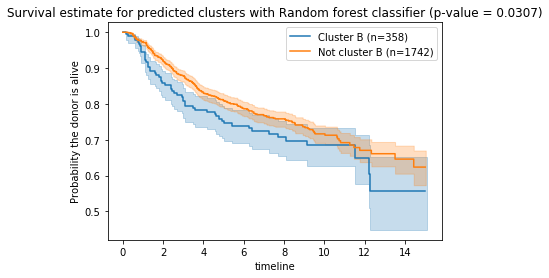

p-value =  0.030716937462178708


In [91]:
# Plot survival curves for prediction on test data
ax = plt.subplot(111)
f1, f2, p = estimate_based_on_clustering(pred_data, ax)
plt.ylabel("Probability the donor is alive")
plt.title("Survival estimate for predicted clusters with Random forest classifier (p-value = %.4f)" %p)
plt.show()
print("p-value = ", p)